# Set bin size via standard error

_Date: January 16, 2026_

In this notebook, we would like to explore the motivation of setting the bin size, $n$, so that we can estimate the event probability parameter of the likelihood distribution to within a certain confidence interval of the true parameter value.

Specifically, we consider the multinomial likelihood model,
$$
\mathbf{x} \sim \textrm{Multinomial}(n, \mathbf{\pi})
$$
for a vector of counts $\mathbf{x} \in \mathbb{N}^V$ and event probability parameter $\mathbf{\pi} \in \Delta_V$.

In [1]:
import jax

from jax import lax, vmap
import jax.numpy as jnp
import jax.random as jr
import jax.scipy as jsp
import numpy as np
import scipy as sp


import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns

## Empirical maximum event probability vs. window size

**Load experimental data**

`session_syllables` is a matrix of `(n_sessions, session_length)` of syllable indices in $\{0,\ldots,89\} \times \{90\}$.
Syllable 90 is the placeholder id for truncated syllables and should not be considered in the analyses.

The data is recorded at 30 fps, and each session is 20 minutes long (36000 frames per session).

In [2]:
DATASET_DIR = "/home/groups/swl1/eyz/data/moseq-drugs/"

filepath = DATASET_DIR + "syllable_sequence_data.npz"

data = {}
with np.load(filepath) as f:
    session_syllables = f['session_syllables']

print(f"session_syllables:\tshape={session_syllables.shape}, dtype={session_syllables.dtype}")

# --------------------------------------------------------------------------------------------
n_sessions, session_length = session_syllables.shape
n_syllables = 90
fps = 30

session_syllables:	shape=(500, 36000), dtype=uint8


**Sweep across bin sizes and evaluate event probabilities.**

In [41]:
def count_events(state_seq, n_states):
    """Count number of occurences of each state in a sequence.

    Parameters
        state_seq: shape (L), int array
            Sequence of state indices, values ranging from [0, n_states)
        n_states: int
            Number of unique states
    
    Return
        counts: shape (n_states,) int array
            Number of occurencs of each state.
            counts.sum() == L
    """

    init_counts = jnp.zeros(n_states, dtype=int)

    def _count(carry, x):
        return carry.at[x].add(1), None
    
    counts, _ = lax.scan(_count, init_counts, xs=state_seq)

    return counts

def get_binned_event_probs(state_seq, n_states, bin_size, overlap_frac=0):
    stride = int(bin_size * (1-overlap_frac))
    
    # Count occurences of each syllable id in a bin
    start_idxs = jnp.arange(0, len(state_seq) - bin_size + 1, stride)
    probs = vmap(
        lambda start: count_events(
            lax.dynamic_slice(state_seq, (start,), (bin_size,)),
            n_states+1
        )
    )(start_idxs)  # shape (n_bins, n_states + 1)

    # Discard the dummy syllable
    probs = probs[...,:-1]  # shape (n_bins, n_states)

    # Convert counts to frequency.
    # Since we tossed out the dummy syllables, probs.sum(axis=-1) <= bin_size
    probs /= probs.sum(axis=-1, keepdims=True)

    return probs


In [4]:
bin_sizes_sec = jnp.array([1, 10, 30, 60, 2*60, 5*60, 10*60, 20*60])
bin_sizes = bin_sizes_sec * 30

probs_by_bin_size = [
    vmap(
        get_binned_event_probs, in_axes=(0,None,None)
    )(session_syllables, n_syllables+1, bin_size)
    for bin_size in bin_sizes
]  # use list, because number of bin sizes (axis 1) will vary vs. bin size

# Print out array shapes.
[probs.shape for probs in probs_by_bin_size]

[(500, 1200, 91),
 (500, 120, 91),
 (500, 40, 91),
 (500, 20, 91),
 (500, 10, 91),
 (500, 4, 91),
 (500, 2, 91),
 (500, 1, 91)]

**Inspect the distribution of event probabilites**

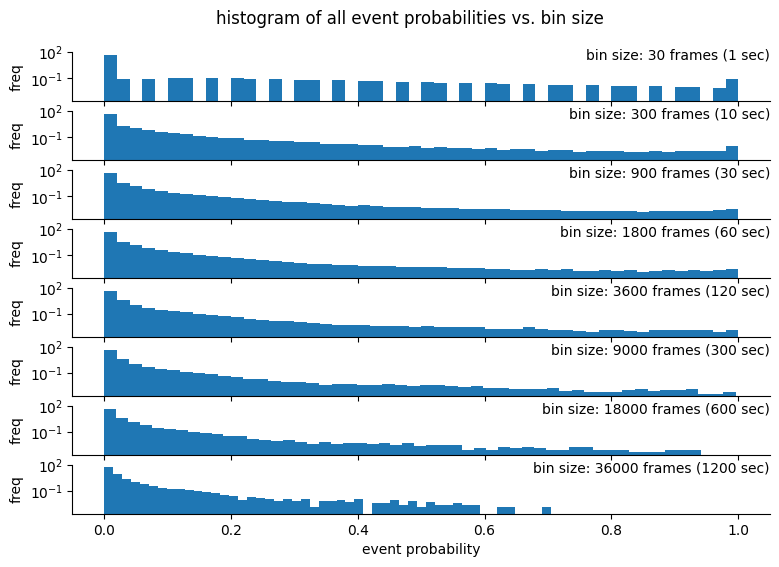

In [5]:
fig, axs = plt.subplots(
    nrows=len(bin_sizes), sharex=True,
    ncols=1, sharey=True,
    figsize=(9,6),
)

for ax, probs, bin_size in zip(axs, probs_by_bin_size, bin_sizes):
    ax.hist(probs.ravel(), bins=50, density=True, log=True)
    ax.set_title(
        f"bin size: {bin_size} frames ({int(bin_size/30)} sec)",
        y=0.9, va='top', x=1, ha='right',
        fontsize='medium',
    )
    ax.set_ylabel('freq')

axs[-1].set_xlabel("event probability")
fig.suptitle("histogram of all event probabilities vs. bin size", y=0.95)
sns.despine()

As expected, smaller bin sizes result in more instances of large event probability.
We see a U-shape imposed on the left skew -- this is because when there are instances of large event probabilities,
the other $V-1$ events will exhibit much smaller event probabilities.

In [6]:
pcts = jnp.array([100, 99.9, 99.5, 99, 95, 90])
probs_by_pct_and_bin_size = jnp.array(
    [
        [jnp.nanpercentile(probs, pct) for probs in probs_by_bin_size]
        for pct in pcts
    ]
)  # (n_pcts, n_bin_sizes)


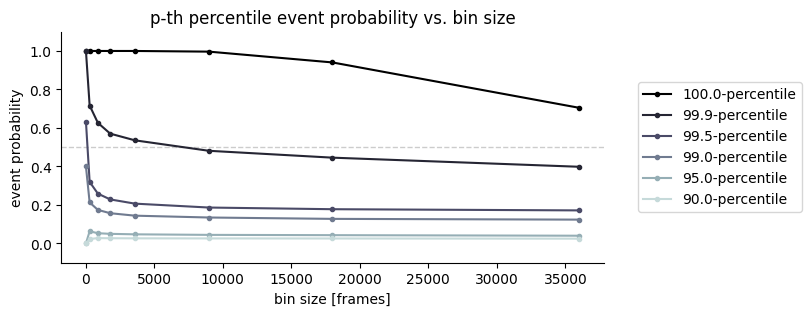

In [7]:
# Cmap goes from darkest to lightest
# Add a few extra elements so that last few elements are not white
pct_cm = mpl.cm.bone(np.linspace(0,1, num=len(pcts)+1))

fig, ax = plt.subplots(figsize=(7,3))
for i, (pct, probs) in enumerate(zip(pcts, probs_by_pct_and_bin_size)):
    ax.plot(bin_sizes, probs, marker='.', color=pct_cm[i], label=f"{pct:.1f}-percentile")

ax.set_ylim(-0.1,1.1)

ax.set_xlabel('bin size [frames]')
ax.set_ylabel('event probability')

ax.axhline(0.5, color='0.8', zorder=0, ls='--', lw=1)

ax.legend(loc='center left', bbox_to_anchor=[1.05,0.5])

ax.set_title('p-th percentile event probability vs. bin size')
sns.despine()


The 99.9-th percentile event probability is much lower than the 100th-percentile (aka max) event probability for all bin sizes >30 frames (1 sec). This suggests that there are a few outlier bins where a single event (syllable) may dominate that entire bin, but it is within reason to ignore.

At the same time, the worst case event probability is at $p=0.5$, so the exact choice of robust max may be irrelevant.

**For now, we precede with defining our "robust max" as the 99.9% percentile event probabilities.**

In [27]:
robust_max_probs_by_bin_size = jnp.array(
    [jnp.nanpercentile(probs, 99.9) for probs in probs_by_bin_size]
)

**Now, let's examine how optimal bin size changes as a function of confidence level.**

In [8]:
def calculate_nmin(eps, max_prob):
    max_prob = jnp.minimum(max_prob, 0.5)
    return max_prob * (1-max_prob) / (eps**2)


# Here, we present an example of what nmins is
x_probs = jnp.linspace(0,1,100)
epsilons = jnp.array([0.01, 0.02, 0.05, 0.10])

nmins_by_epsilons_dummy = vmap(
    vmap(calculate_nmin, in_axes=(None,0)),
    in_axes=(0,None)
)(epsilons, x_probs)  # shape (n_epsilons, n_probs)

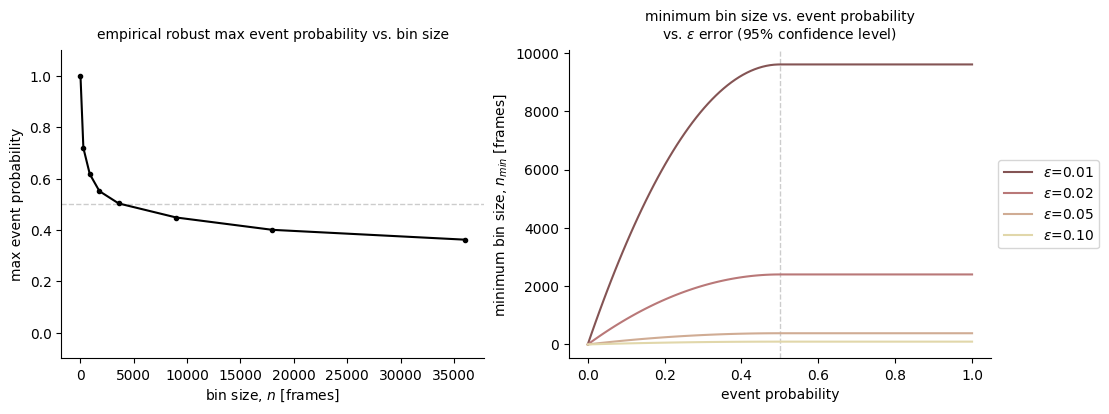

In [115]:
z = 1.96  # 95% confidence level

# Cmap goes from darkest to lightest
# Add a few extra elements so that last few elements are not white
eps_cm = mpl.cm.pink(np.linspace(0,1, num=len(epsilons)+3))[1:]

fig, axs = plt.subplots(ncols=2, figsize=(12,4))

# Robust max event probs vs. bin size
ax = axs[0]
ax.plot(bin_sizes, robust_max_probs_by_bin_size, color='k', marker='.')

ax.set_ylim(-0.1,1.1)
ax.set_xlabel(r"bin size, $n$ [frames]")
ax.set_ylabel("max event probability")

ax.axhline(0.5, color='0.8', zorder=0, ls='--', lw=1)
ax.set_title(
    "empirical robust max event probability vs. bin size",
    va='bottom', fontsize='medium'
)

# n_mins
ax = axs[1]
for i, (eps, nmins) in enumerate(zip(epsilons, nmins_by_epsilons_dummy)):
    ax.plot(
        x_probs, (z**2) * nmins,
        color=eps_cm[i], label=r"$\epsilon$=" + f"{eps:.2f}"
    )
 
ax.set_xlabel("event probability")
ax.set_ylabel(r"minimum bin size, $n_{min}$ [frames]")

ax.axvline(0.5, color='0.8', zorder=0, ls='--', lw=1)
ax.legend(loc='center left', bbox_to_anchor=[1.0,0.5])

ax.set_title(
    r"minimum bin size vs. event probability"
    + "\n" + r"vs. $\epsilon$ error (95% confidence level)",
    va='bottom', fontsize='medium'
)
sns.despine()

In [52]:
# Now, compute the real ones
nmins_by_epsilons = vmap(
    vmap(calculate_nmin, in_axes=(None,0)),
    in_axes=(0,None)
)(epsilons, robust_max_probs_by_bin_size)  # shape (n_epsilons, n_bin_sizes)

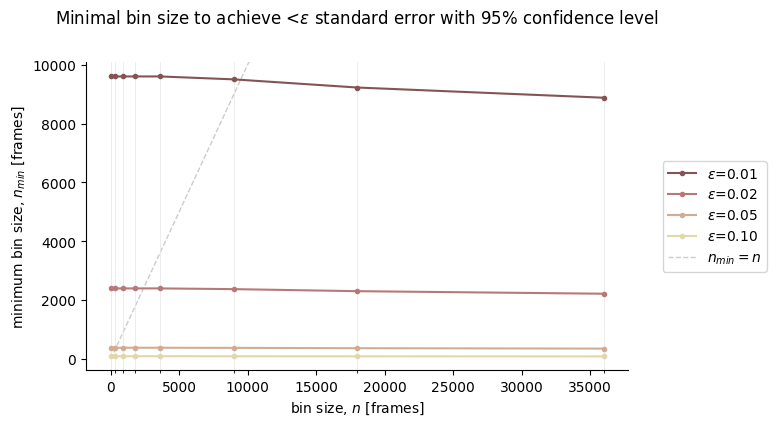

In [88]:
z = 1.96  # 95% confidence level

# Cmap goes from darkest to lightest
# Add a few extra elements so that last few elements are not white
eps_cm = mpl.cm.pink(np.linspace(0,1, num=len(epsilons)+3))[1:]

fig, ax = plt.subplots(figsize=(7,4))

for i, (eps, nmins) in enumerate(zip(epsilons, nmins_by_epsilons)):
    ax.plot(
        bin_sizes, (z**2) * nmins,
        marker='.', color=eps_cm[i],
        label=r"$\epsilon$=" + f"{eps:.2f}"
    )

# Save the old ylims; reference line will mess this up
ylims = ax.get_ylim()

# Plot identity reference line
ax.plot(
    [0,bin_sizes[-1]], [0,bin_sizes[-1]],
    color='0.8', zorder=0, ls='--', lw=1,
    label=r"$n_{min} = n$"
)

# Reset ylims
ax.set_ylim(*ylims)

# Add grid lines at the swept bin sizes
ax.set_xticks(bin_sizes, minor=True)
ax.grid(axis='x', which='minor', lw=0.5, zorder=0, c='0.9')

# Add labels
ax.set_xlabel(r"bin size, $n$ [frames]")
ax.set_ylabel(r"minimum bin size, $n_{min}$ [frames]")

ax.legend(loc='center left', bbox_to_anchor=[1.05,0.5])

ax.set_title(r'Minimal bin size to achieve <$\epsilon$ standard error with 95% confidence level', y=1.1)

sns.despine()


$\epsilon$ | $n^\star$ [frames] | $n^\star$ [sec] | $n^\star$ [min]
---------- | ------------- | ---------- | ----------
0.01       | 9000+ bins    | ~300 sec   | 5 min
0.02       | ~2250 bins    | ~75 sec    | 1.25 min
0.05       | 300 bins      | 10 sec     |
0.10       | 30 bins       | 1 sec |

These results should be consistent with the worst case $n_{\textrm{min}}$ (i.e at $p=0.5$), if we were just to read it off the $n_{\textrm{min}}$ vs. event probability figure above.

In [20]:
nmins_worstcase = (1.96)**2 * vmap(lambda eps: calculate_nmin(eps, 0.5))(epsilons)
for eps, nmin in zip(epsilons, nmins_worstcase):
    print(f"epsilon={eps:.2f}: n_min={int(nmin)}")


epsilon=0.01: n_min=9604
epsilon=0.02: n_min=2401
epsilon=0.05: n_min=384
epsilon=0.10: n_min=96


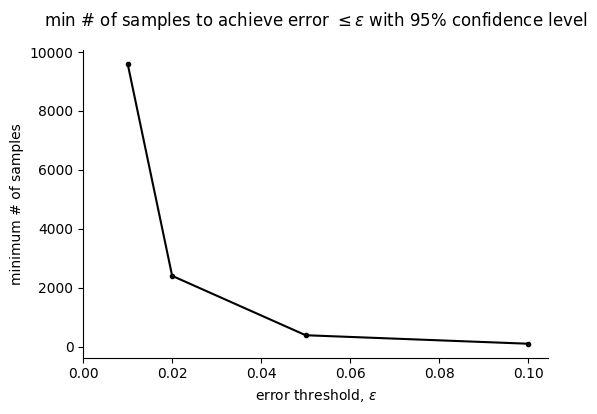

In [62]:
fig, ax = plt.subplots(figsize=(6,4))

ax.plot(epsilons, nmins_worstcase, c='k', marker='.')
ax.set_xlabel(r"error threshold, $\epsilon$")
ax.set_ylabel(r"minimum # of samples")
ax.set_xlim(left=0)

ax.set_title(r'min # of samples to achieve error $\leq \epsilon$ with 95% confidence level', y=1.05)
sns.despine()

So, now let's choose bin size $n_\textrm{min}=2400$ ($1.3$ minutes), and calculate the corresponding error threshold for different event probabilities.

In [58]:
bin_size = n = 2000

binned_freqs = vmap(
    get_binned_event_probs, in_axes=(0,None,None)
)(session_syllables, n_syllables+1, bin_size)[...,:n_syllables]

binned_freqs.shape

(500, 18, 90)

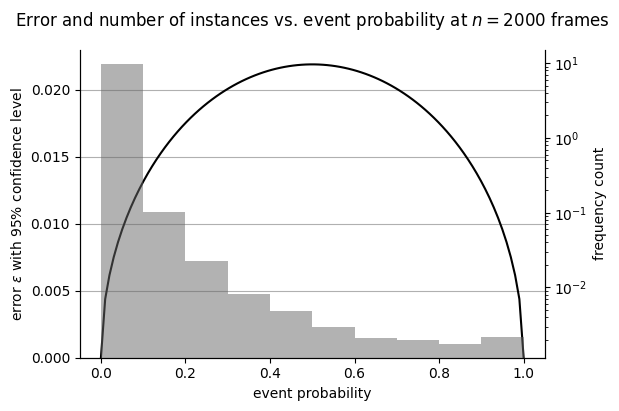

In [63]:
z = 1.96  # 95% confidence level

x_probs = np.linspace(0,1,100)
y_eps = z * np.sqrt(x_probs * (1-x_probs) / n)

fig, ax = plt.subplots(figsize=(6,4))
ax.plot(x_probs, y_eps, color='k')

ax.set_ylim(bottom=0)
ax.grid(axis='y')
ax.set_xlabel("event probability")
ax.set_ylabel(r"error $\epsilon$ with 95% confidence level")

ax_hist = ax.twinx()
ax_hist.hist(
    binned_freqs.ravel(),
    density=True, log=True,
    color='0.4', alpha=0.5, zorder=1
)
ax_hist.set_ylabel("frequency count")

sns.despine(right=False)

ax.set_title(f"Error and number of instances vs. event probability at $n={bin_size}$ frames", y=1.05);

**Figure** 95% confidence level error threshold (black line) vs. event probability, and observed event probability count (gray histogram) at a bin size of $n=2000$ (1 minutes).
Our analyses show that when binning at $n=2000$, the worst case error (which occurs at event probability $p=0.5$) can result in a parametere estimation error of 0.02.
However, this is the worst case error, and the histogram of observed event probabilities at this bin size is heavily right skewed. The associated error levels at this bin size and event probabilties are less than an error 0.02.
